## Part 1: Importing Libraries

In [1]:
from src.modules import data_preprocessing as dp
from src.modules import data_visualization as dv
from src.modules import modeling as md

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

## Part 2: Download Dataset

In [3]:
# Declare the ticker symbol. Here we use 5 stocks "AAPL MSFT AMD GOOG META" as an example.
tickers = "AMD"

In [4]:
# Download the data from Yahoo Finance
df = dp.download_data(tickers)

[*********************100%%**********************]  1 of 1 completed


In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-09,3.63,3.72,3.62,3.69,3.69,23646200
2013-09-10,3.78,3.87,3.77,3.87,3.87,33201100
2013-09-11,3.87,3.89,3.74,3.82,3.82,24009100
2013-09-12,3.76,3.80,3.69,3.75,3.75,28947700
2013-09-13,3.75,3.87,3.72,3.83,3.83,25331400


## Part 3: EDA & Preprocessing

In [6]:
# Set global style
dv.set_global_style()

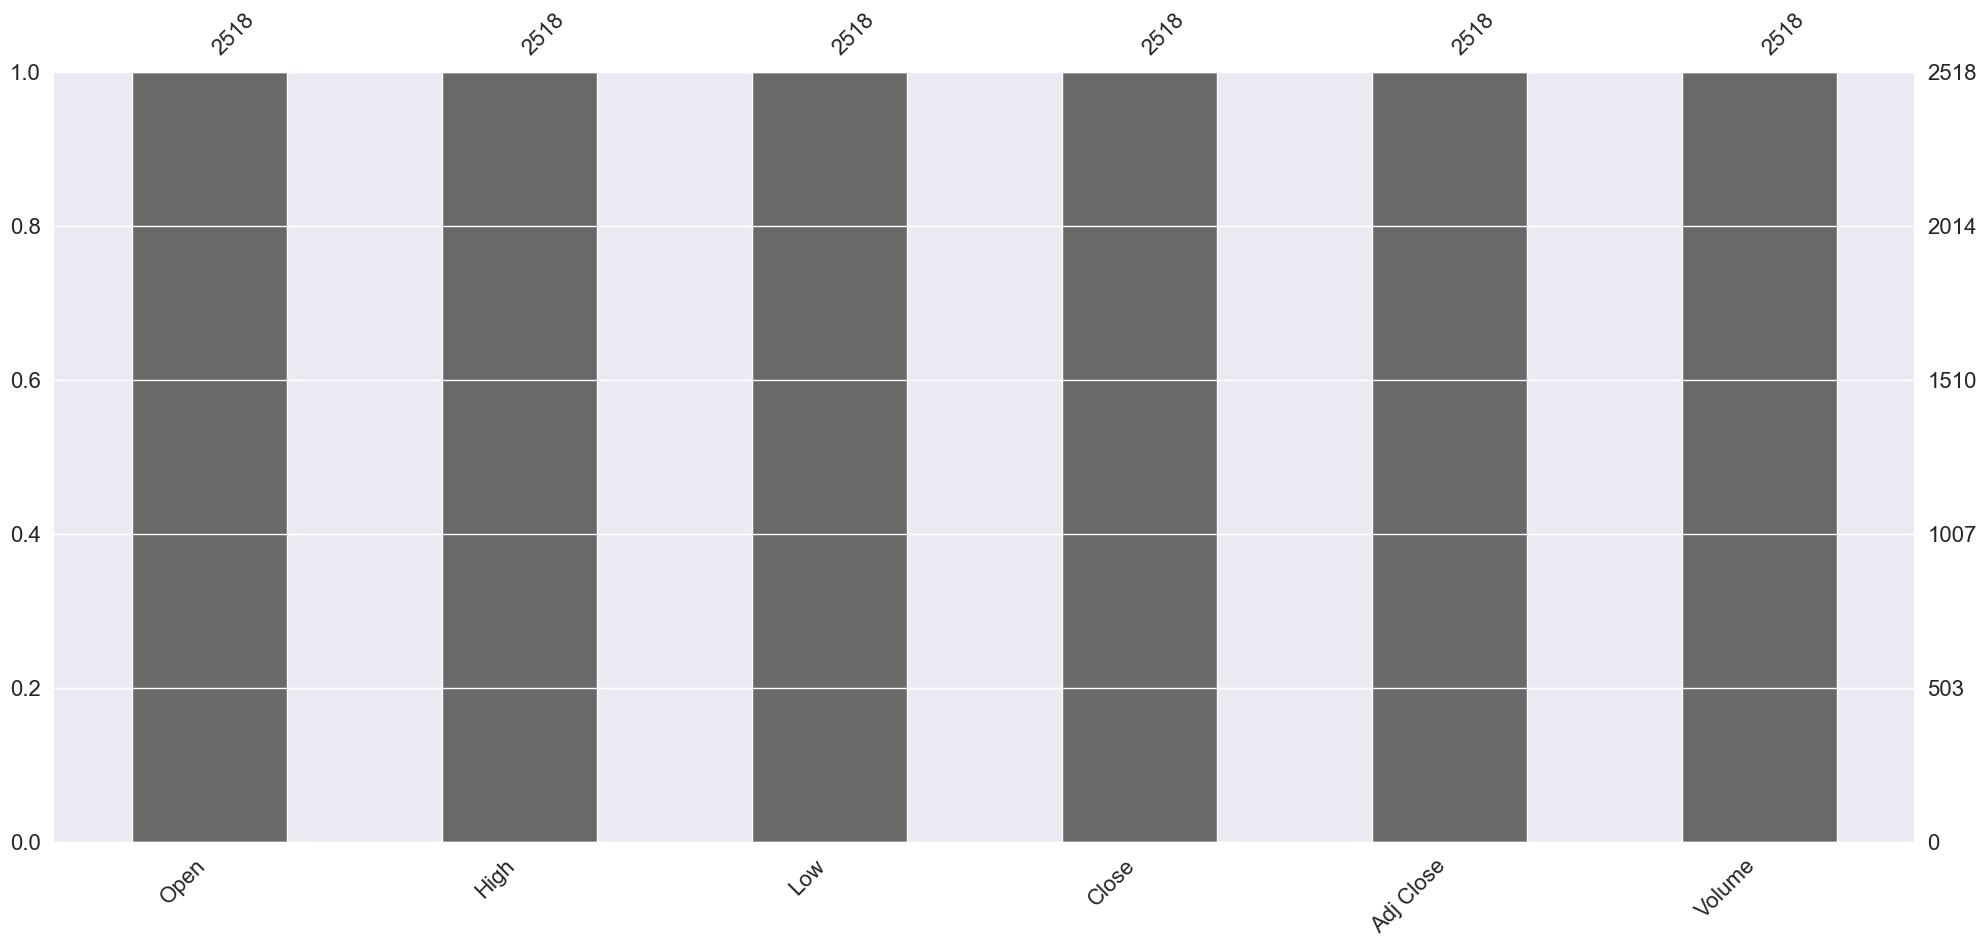

In [7]:
# Checking missing value
dv.plot_missing_values(df)

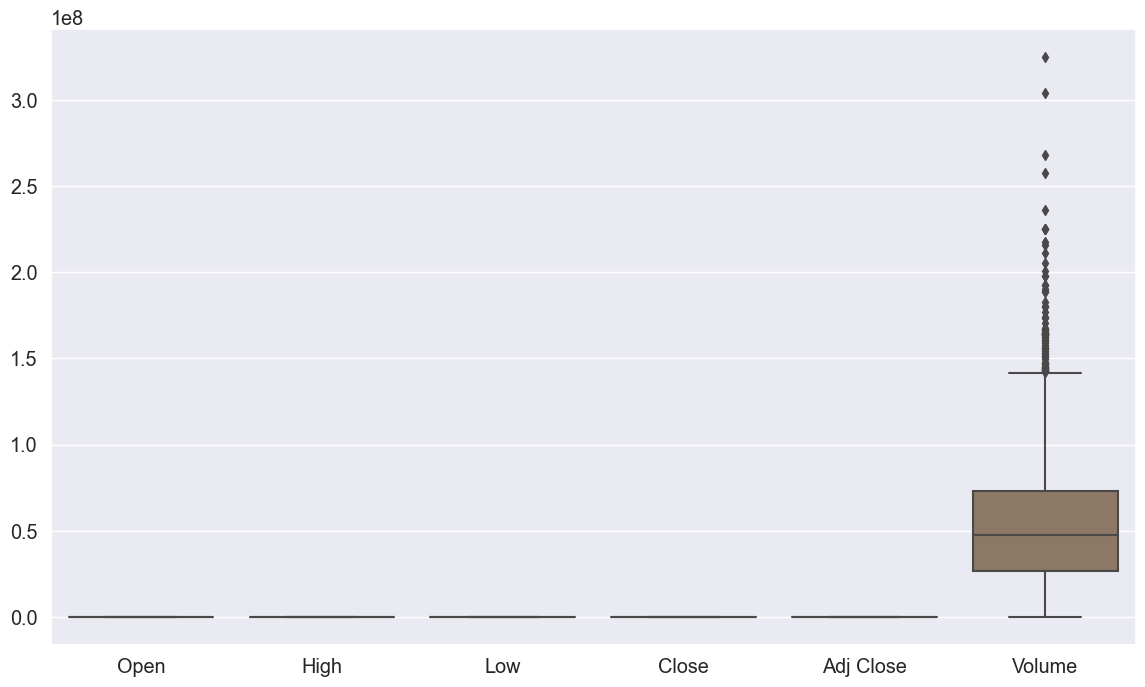

In [8]:
# Visualize the outliers data
dv.plot_outliers(df)

In [9]:
# Clean the data after checking the missing values and outliers
df = dp.clean_data(df)

In [10]:
# Change index to lowercase for convenience
df.index.name = df.index.name.lower()

In [11]:
df.shape

(2518, 6)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-09-09 to 2023-09-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2518 non-null   float64
 1   high       2518 non-null   float64
 2   low        2518 non-null   float64
 3   close      2518 non-null   float64
 4   adj close  2518 non-null   float64
 5   volume     2518 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.7 KB


In [13]:
df.describe()

,open,high,low,close,adj close,volume
count,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03
mean,39.648336,40.466350,38.796684,39.643566,39.643566,5.398487e+07
std,40.728378,41.560776,39.827428,40.700970,40.700970,3.787708e+07
min,1.620000,1.690000,1.610000,1.620000,1.620000,0.000000e+00
25%,4.120000,4.192500,4.070000,4.122500,4.122500,2.679100e+07
50%,19.350000,19.860000,18.825000,19.300000,19.300000,4.733905e+07
75%,78.484999,79.702501,77.015001,78.369997,78.369997,7.280720e+07
max,163.279999,164.460007,156.100006,161.910004,161.910004,3.250584e+08


Summary of EDA
- There are 2518 data points, 6 features
- 5 features are numerical
- There are some outliers in `meta` feature, using data cleaning technique to set the value within an appropriate threshold
- There is no missing nor duplicated values

## Part 4: Data Transformation

In [ ]:
# # get the adj close values
# close_data = df.filter(['adj close'])
# dataset = close_data.values

# # select a subset of the data for training purpose
# # the remaining set of the data is for validation
# num_training_points = int(np.ceil(len(dataset) * .80))
# print(num_training_points)

In [27]:
feat = ['adj close']

In [31]:
def scale_data(dataframe, feat):
    # get the adj close values
    close_data = dataframe.filter(feat)
    dataset = close_data.values

    # select a subset of the data for training purpose
    # the remaining set of the data is for validation
    # Get 80% of the data for training
    num_training_points = int(np.ceil(len(dataset) * 0.8))
    # X_train = dataset[0:num_training_points, :]
    # X_test = dataset[num_training_points:, :]

    # scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_dataset = scaler.fit_transform(dataset)

    # split the data into train and test scaled data sets
    scaled_data_train = scaled_dataset[0:int(num_training_points), :]
    # scaled_data_test = scaled_data[int(num_training_points)-window_size:, :]

    return dataset, scaled_dataset, scaled_data_train, num_training_points, scaler

## Part 5: Feature Engineering

In [29]:
def convert_to_supervised(data, window_size=60):
    # convert the data into a supervised learning problem
    # the number of time steps to look back is the window size
    # the next day's adjusted close price is the label

    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    
    X, y = np.array(X), np.array(y)

    # reshape the data into the shape accepted by the LSTM
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y

In [17]:
# Transform the data to supervised learning
window_size = 60 # window size is the number of previous days used to predict the next day. 

In [25]:
def get_features_labels(dataframe, ticker, window_size=60):
    dataset, scaled_dataset, scaled_data_train, num_training_points, scaler = scale_data(dataframe, feat)
    features, labels = convert_to_supervised(scaled_data_train, window_size)
    return features, labels, dataset, scaled_dataset, num_training_points, scaler

## Part 6: Modeling

In [35]:
# # Modeling
# model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(units = 128, return_sequences = True, input_shape = (features.shape[1], 1)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(units = 64, return_sequences = True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(units = 32, return_sequences = False),
#     # tf.keras.layers.Dropout(0.2),
#     # tf.keras.layers.LSTM(units = 50),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(units = 25),
#     tf.keras.layers.Dense(units = 1)
# ])

In [35]:
def build_and_train_model(features, labels):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(features.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    # cp = ModelCheckpoint('model/', save_best_only=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    # Train the model
    # history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1, callbacks=[cp])
    # epoch = 10 for developoment, need to increase to 100 for real training
    model.fit(features, labels, epochs = 10, batch_size = 32, verbose = 1)
    return model

In [36]:
features, labels, dataset, scaled_dataset, num_training_points, scaler = get_features_labels(dataframe=df, ticker='amd', window_size=60)

In [37]:
model = build_and_train_model(features, labels)

Epoch 1/10
62/62 [==============================] - 26s 174ms/step - loss: 0.0027 - root_mean_squared_error: 0.0516
Epoch 2/10
62/62 [==============================] - 9s 151ms/step - loss: 4.4496e-04 - root_mean_squared_error: 0.0211
Epoch 3/10
62/62 [==============================] - 9s 153ms/step - loss: 4.7381e-04 - root_mean_squared_error: 0.0218
Epoch 4/10
62/62 [==============================] - 9s 146ms/step - loss: 4.6787e-04 - root_mean_squared_error: 0.0216
Epoch 5/10
62/62 [==============================] - 9s 148ms/step - loss: 6.3068e-04 - root_mean_squared_error: 0.0251
Epoch 6/10
62/62 [==============================] - 9s 143ms/step - loss: 3.8516e-04 - root_mean_squared_error: 0.0196
Epoch 7/10
62/62 [==============================] - 9s 149ms/step - loss: 3.2728e-04 - root_mean_squared_error: 0.0181
Epoch 8/10
62/62 [==============================] - 9s 151ms/step - loss: 3.3452e-04 - root_mean_squared_error: 0.0183
Epoch 9/10
62/62 [==============================] -

In [71]:
# Function to generate the future forecasts
def predict(n_past = 0, n_future = 5):

    # prepare data for forecasting
    forecast_data = df[['adj close']]

    z = scaler.transform(forecast_data)

    X, y = [], []

    for i in range(window_size, len(z)):
        X.append(z[i - window_size: i])
        y.append(z[i])

    X, y = np.array(X), np.array(y)

    X_past = X[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        X_past = np.append(X_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model.predict(X_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])
  
    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    return y_future

In [72]:
y_pred = predict()

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


[0.65175615]
(1, 60, 1) (1,)
(1, 60, 1)
1/1 [==============================] - 0s 145ms/step
(1, 60, 1)
1/1 [==============================] - 0s 206ms/step
(1, 60, 1)
1/1 [==============================] - 0s 96ms/step
(1, 60, 1)
1/1 [==============================] - 0s 99ms/step
(1, 60, 1)
1/1 [==============================] - 0s 140ms/step
(1, 60, 1) (1, 1)
[[0.6391272]]


In [58]:
print(y_pred)

[104.3931   104.58879  104.57149  104.38011  104.065704]


In [74]:
vertices = np.array([65],np.int32)
print(vertices.shape)
pts = vertices.reshape((1,1,1))

(1,)


In [76]:
print(pts.shape)

(1, 1, 1)


In [46]:
# prepare data for forecasting
forecast_data = df[['adj close']]

z = scaler.transform(forecast_data)

X, y = [], []

for i in range(window_size, len(z)):
    X.append(z[i - window_size: i])
    y.append(z[i])

X, y = np.array(x), np.array(y)

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


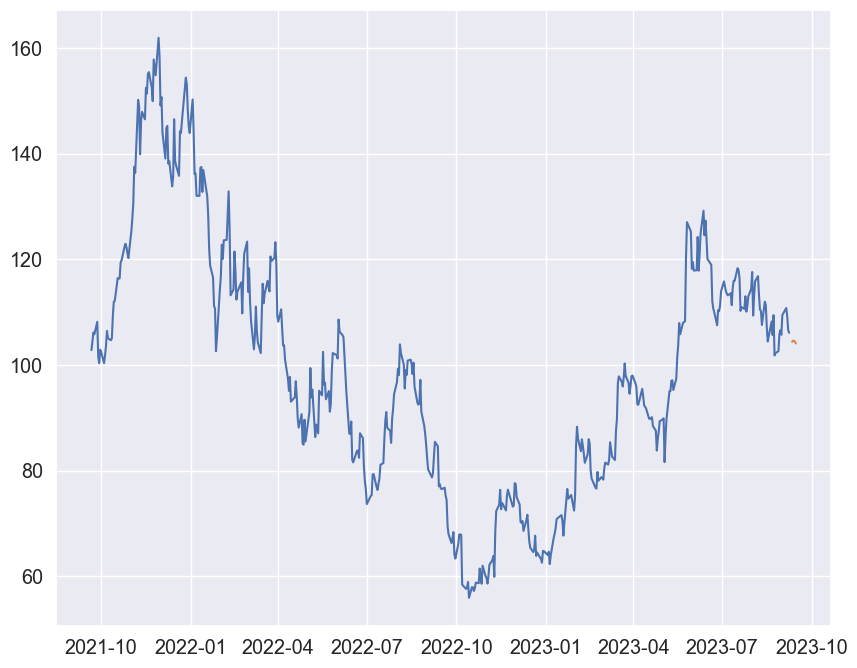

In [52]:
# forecast the next 5 days
y_future_5 = generate_future_forecasts(n_past=0, n_future=5, features=X, labels=y)

In [55]:
# Save the model for future use
import pickle 
pickle.dump(model,open('model_amd.pkl','wb'))